<a href="https://colab.research.google.com/github/Lememski/Wall-E-Project-1---IAT-360/blob/main/computervisionproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

Import the google drive: https://drive.google.com/drive/folders/1q4gX01EEeXj1qo-daa3uRjRfxSKtgMQT?usp=drive_link

/content/drive/MyDrive/IAT 360 Project1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Dataset Description

 Add content Later





Defining paths to train and test folders.

In [ ]:
test_dir = '/content/drive/MyDrive/IAT 360 Project1/Test'
train_dir = '/content/drive/MyDrive/IAT 360 Project1/Train'

In [ ]:
#set the paths to labels and images directory
Trainlabel_dir= "/content/drive/MyDrive/IAT 360 Project1/Train/labels"
Trainimage_dir="/content/drive/MyDrive/IAT 360 Project1/Train/images"

Validlabel_dir= "/content/drive/MyDrive/IAT 360 Project1/Valid/labels"
Validimage_dir="/content/drive/MyDrive/IAT 360 Project1/Valid/images"

Visualizing somme pictures from the dataset

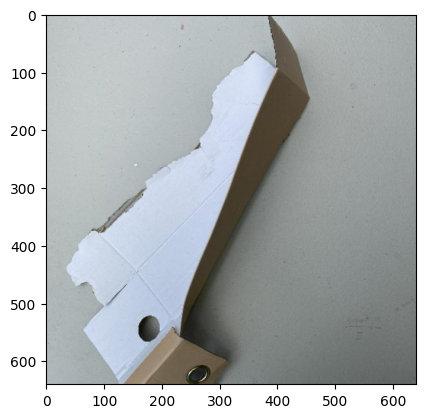

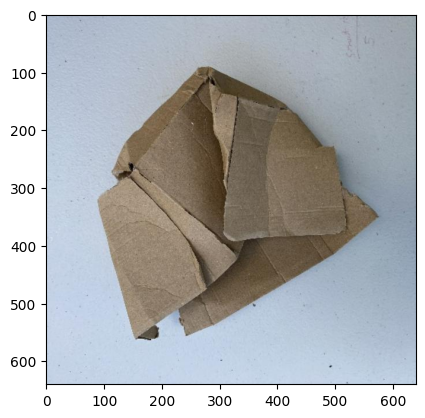

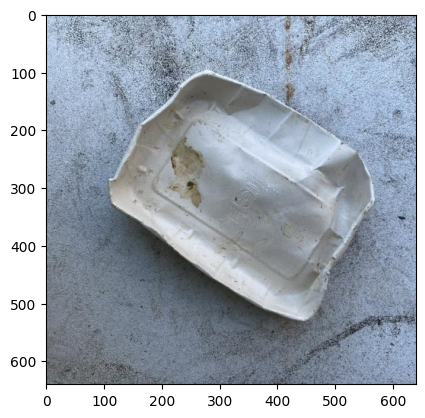

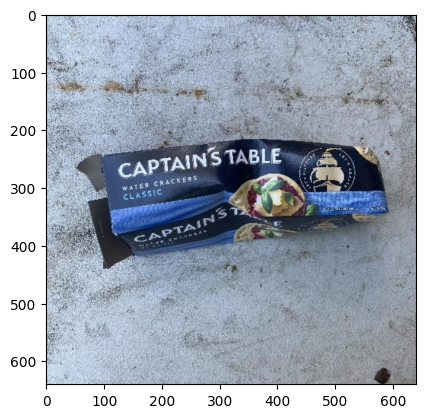

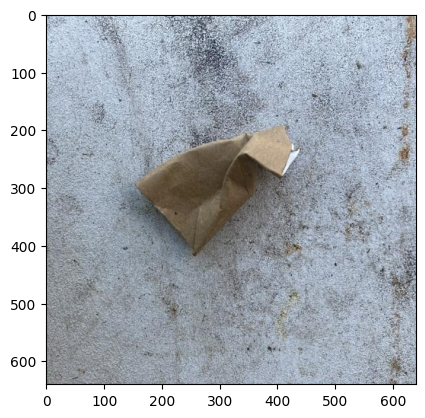

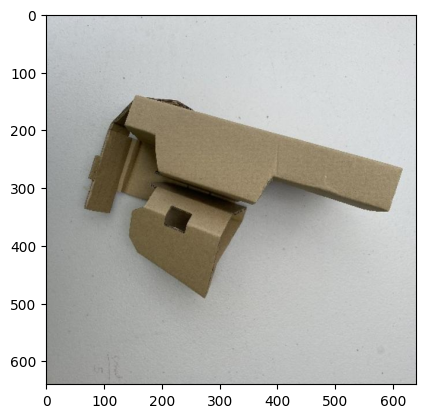

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# When we loaded the original code from the computer vision project we ran into this error: TypeError: Image data of dtype object cannot be converted to float
# This was likely because matplotlib's plt.imshow() expects images in a specific format, while cv2.imread() loads images in BGR (Blue-Green-Red)
# To fix this we converted the BGR image to RGB format using cv2.cvtColor()
# We also added a troubleshoot else statement so we would get a string saying images did not load instead of an error

# Visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(Trainimage_dir))):
    # Load the image in BGR format (original)
    img = cv2.imread(os.path.join(Trainimage_dir, image), 1)

    # Check if the image was loaded successfully
    if img is not None:
        # Convert the image from BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.imshow(img_rgb)
        plt.show()
    else:
        print(f"Failed to load image: {image}")

    # Break after displaying 5 images
    if idx == 5:
        break


## Checking Missing Files

Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [ ]:
#The lists of all the images and labels for train and validation set:



train_images=glob.glob(os.path.join(Trainimage_dir,'*.jpg'))
train_labels=glob.glob(os.path.join(Trainlabel_dir,'*.txt'))
val_images=glob.glob(os.path.join(Validimage_dir, '*.jpg'))
val_labels=glob.glob(os.path.join(Validlabel_dir,'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)


In [ ]:
print(len(image_files_val), "  =  ", len(label_files_val))

119   =   119


In [ ]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): {'metal_747', 'plastic_863', 'metal_746', 'plastic_860', 'cardboard_894', 'cardboard_893', 'paper_1036', 'metal_743', 'paper_1034', 'plastic_859', 'plastic_865', 'cardboard_896', 'plastic_864', 'plastic_861', 'paper_1032', 'metal_740', 'metal_744', 'cardboard_892', 'metal_745', 'paper_1031', 'metal_742', 'paper_1033', 'metal_741', 'plastic_862', 'cardboard_895', 'cardboard_898', 'plastic_866', 'paper_1035', 'paper_1037', 'cardboard_897'}
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


We went through and made sure that the above info is correct by checking the data manually.It is not, we did have correlating images to the labels so we chose not to make any action on this information.

# Custom object detection using YOLO

First install and import

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.3/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [ ]:
model = YOLO('yolov8s.pt') # pretrained model

100%|██████████| 21.5M/21.5M [00:00<00:00, 41.2MB/s]


The detailed architecture of the model can be seen from:


In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
%%writefile config.yaml
# Path to dataset and labels
path: /content/drive/MyDrive/IAT_360_Project1

# Define paths to training and validation images
train: /content/drive/MyDrive/IAT 360 Project1/Train  # path to train images folder
val: /content/drive/MyDrive/IAT 360 Project1/Valid    # path to validation images folder

# Class names
names:
  0: cardboard
  1: plastic
  2: paper
  3: metal


Writing config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [ ]:
model.train(data="config.yaml", epochs=50, patience=5, batch=16, lr0=0.001, imgsz=640)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 72.6MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 126MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/IAT 360 Project1/Train/labels.cache... 576 images, 4 backgrounds, 0 corrupt: 100%|██████████| 576/576 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/IAT 360 Project1/Valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.06G     0.9036      2.404      1.432         46        640: 100%|██████████| 36/36 [00:33<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.89s/it]

                   all        119        142       0.19      0.463        0.2      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         4G     0.9092      1.457      1.402         37        640: 100%|██████████| 36/36 [00:14<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        119        142      0.255      0.535      0.278      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         4G      1.011      1.517      1.478         40        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        119        142      0.419      0.282      0.224      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.04G      1.068      1.535      1.528         40        640: 100%|██████████| 36/36 [00:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        119        142      0.432      0.255      0.208      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.02G      1.066      1.484      1.504         42        640: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        119        142      0.395      0.397      0.137     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.87G      1.055      1.473      1.498         46        640: 100%|██████████| 36/36 [00:13<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        119        142      0.572      0.407      0.269      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.86G       1.03      1.464      1.468         42        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        119        142      0.652        0.4      0.265      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.86G     0.9378      1.338      1.421         38        640: 100%|██████████| 36/36 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        119        142      0.502      0.372      0.238      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.88G     0.9504      1.348      1.428         35        640: 100%|██████████| 36/36 [00:14<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        119        142       0.71      0.271      0.315      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.04G     0.9535      1.337      1.412         39        640: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        119        142      0.426      0.335      0.267      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.02G     0.9111      1.287      1.398         43        640: 100%|██████████| 36/36 [00:14<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        119        142      0.468      0.339      0.268      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.86G     0.9066      1.257      1.387         44        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        119        142      0.496      0.457      0.341      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.04G      0.859      1.242      1.352         40        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        119        142      0.752      0.352      0.292      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.86G     0.8552      1.175      1.346         50        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        119        142      0.466      0.291      0.282      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.02G     0.8479      1.179      1.356         42        640: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        119        142      0.674      0.483      0.412      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.86G     0.7865      1.115      1.302         40        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        119        142       0.61      0.469      0.373      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.04G     0.8325      1.128      1.328         44        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        119        142      0.576      0.493      0.346      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.86G     0.8025      1.118       1.31         47        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        119        142      0.571      0.446       0.36      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.02G     0.7883      1.099      1.302         39        640: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        119        142      0.828      0.373      0.455      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.86G     0.7837       1.06      1.286         39        640: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        119        142      0.672        0.4       0.44      0.311
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 15, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



20 epochs completed in 0.118 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


                   all        119        142      0.673      0.481      0.412      0.332
             cardboard          3          3      0.353      0.667      0.343      0.314
               plastic         28         29       0.57      0.641      0.595      0.471
                 paper          1          1          1          0    0.00325     0.0026
                 metal         87        109       0.77      0.616      0.707       0.54
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bc2eeb84370>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/IAT 360 Project1/Valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


                   all        119        142      0.673      0.483      0.413      0.332
             cardboard          3          3      0.348      0.667      0.343      0.314
               plastic         28         29      0.573      0.648      0.601      0.472
                 paper          1          1          1          0    0.00327    0.00262
                 metal         87        109      0.771      0.619      0.706       0.54
Speed: 0.8ms preprocess, 11.1ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs/detect/train2


0.4834630070506142

Showing confusion matrix, that is already stored in detect/train folder

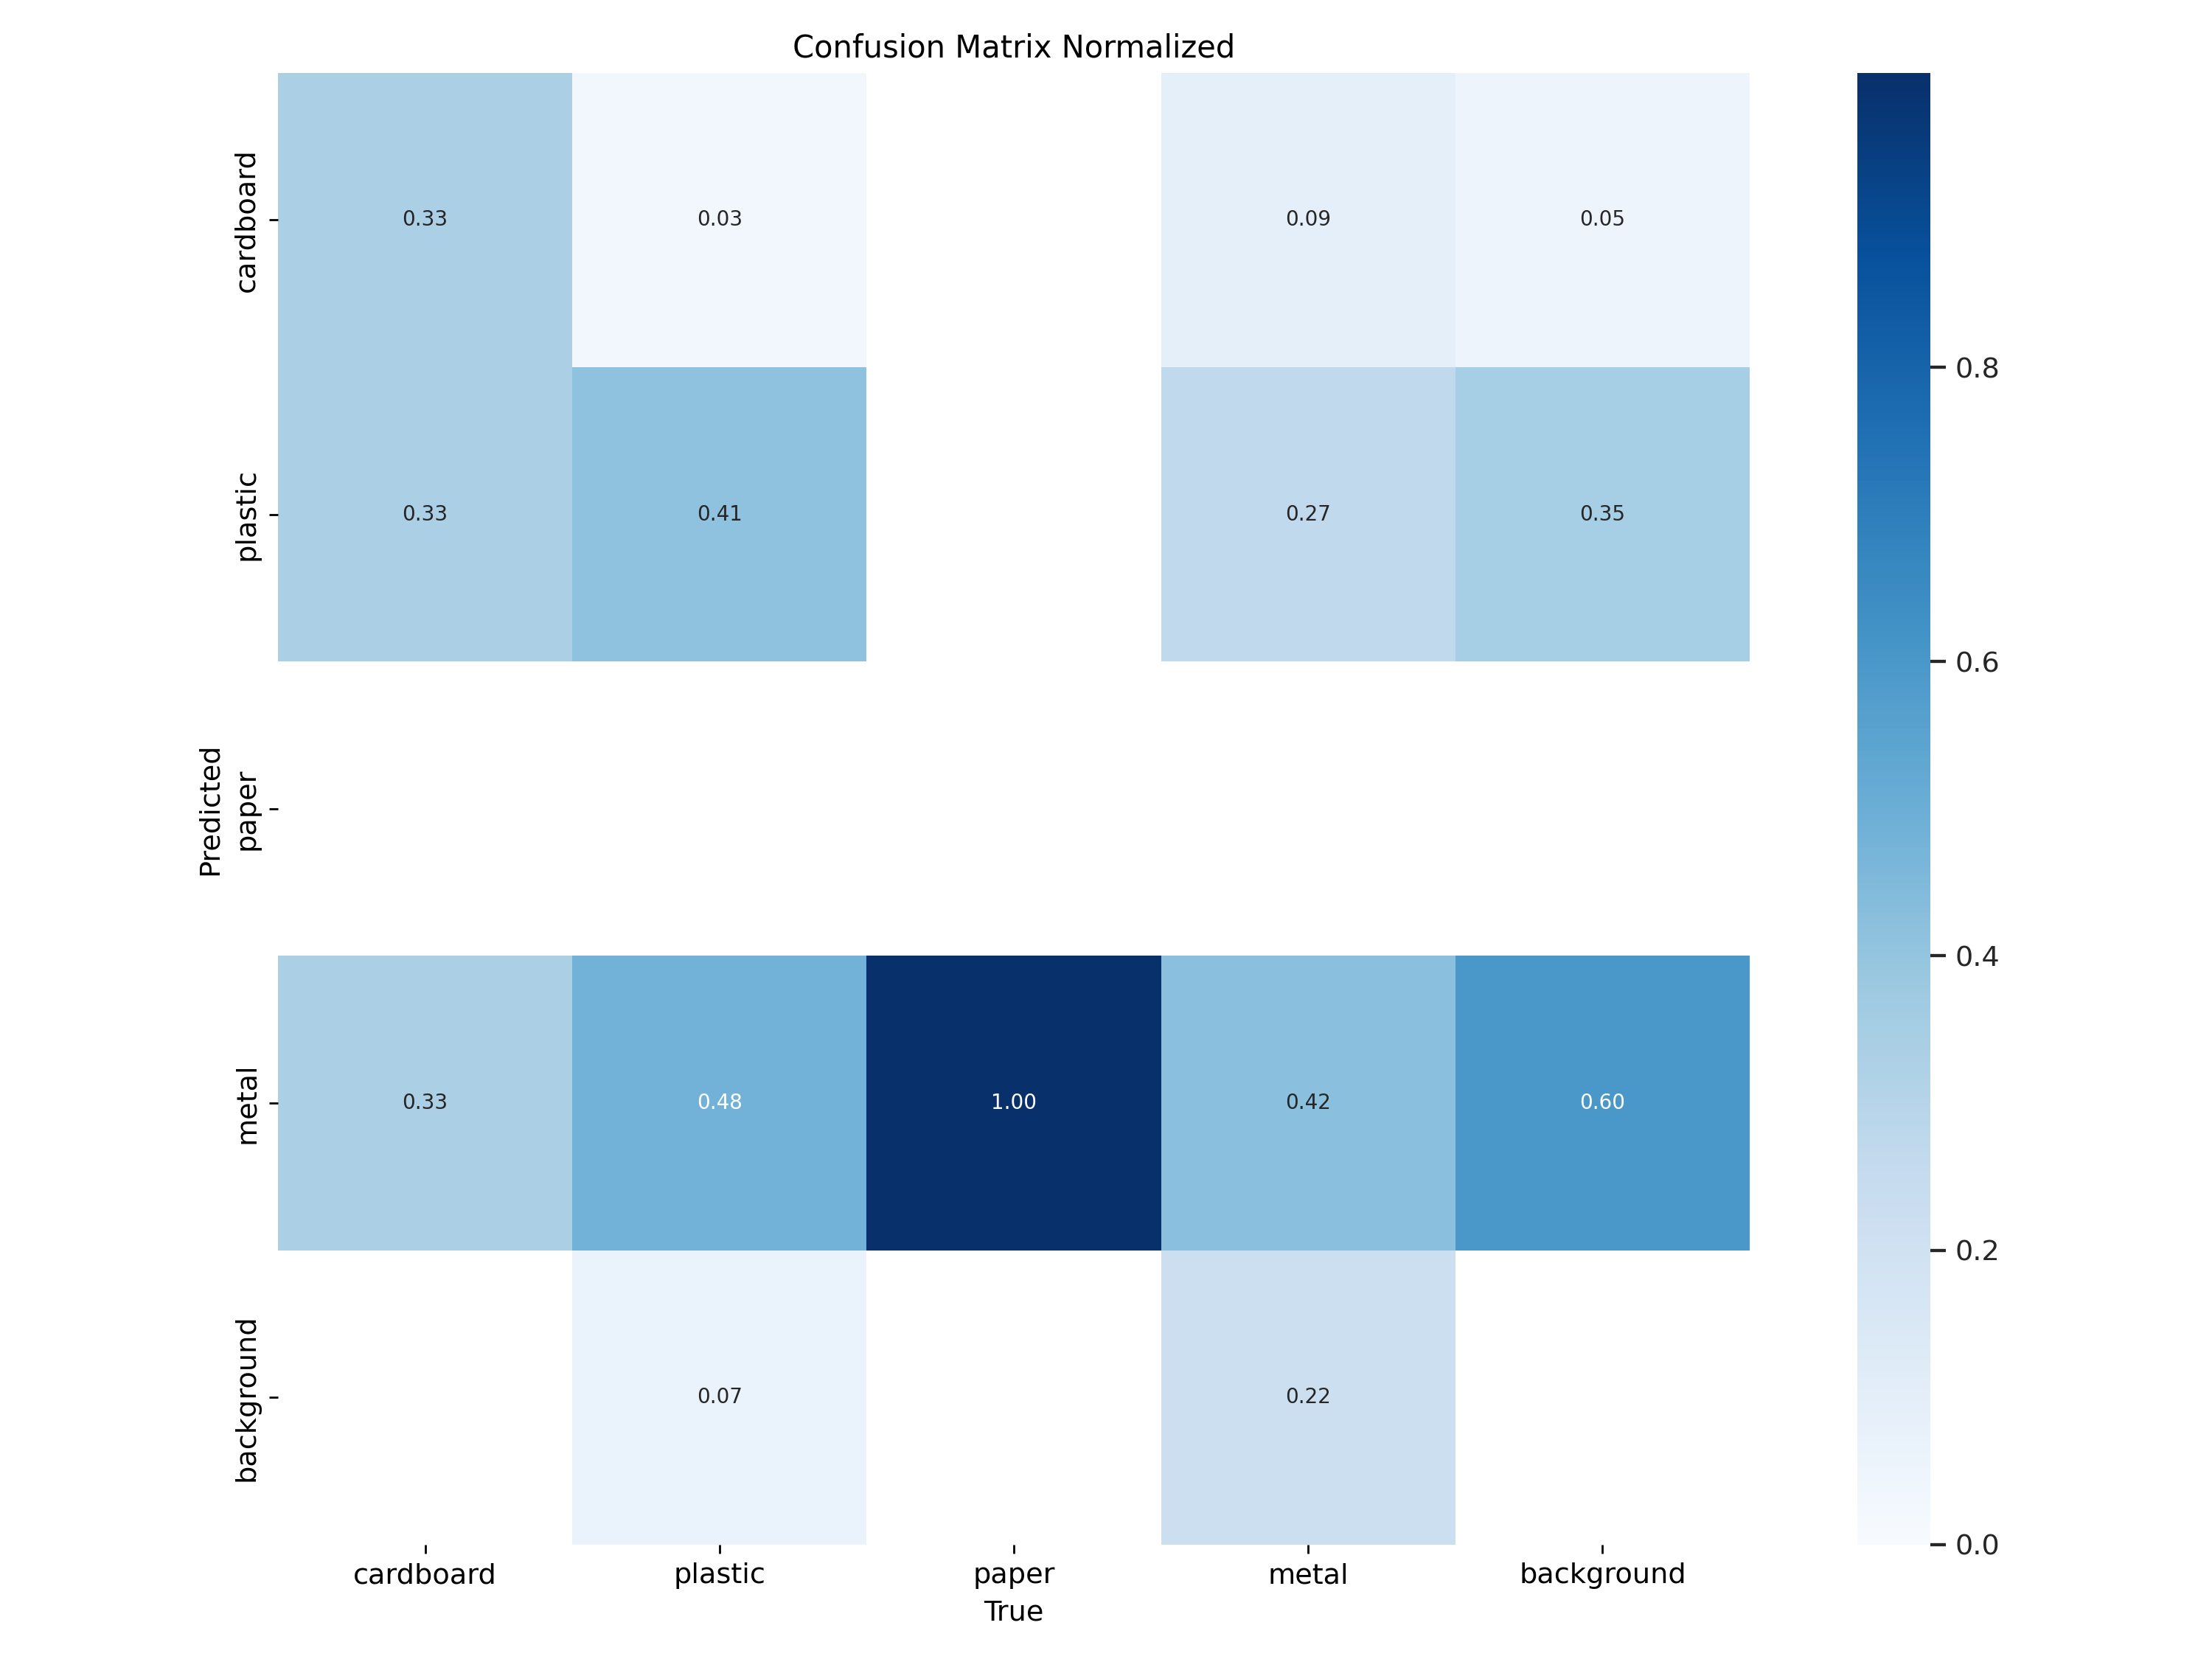

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train/confusion_matrix_normalized.png')

##Prediction

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('https://s3.amazonaws.com/tc-us-prod/download_resource/downloads/2507/aluminum-cans-thumbnail-US-image.jpg', save=True)

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camer

KeyboardInterrupt: 

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camer

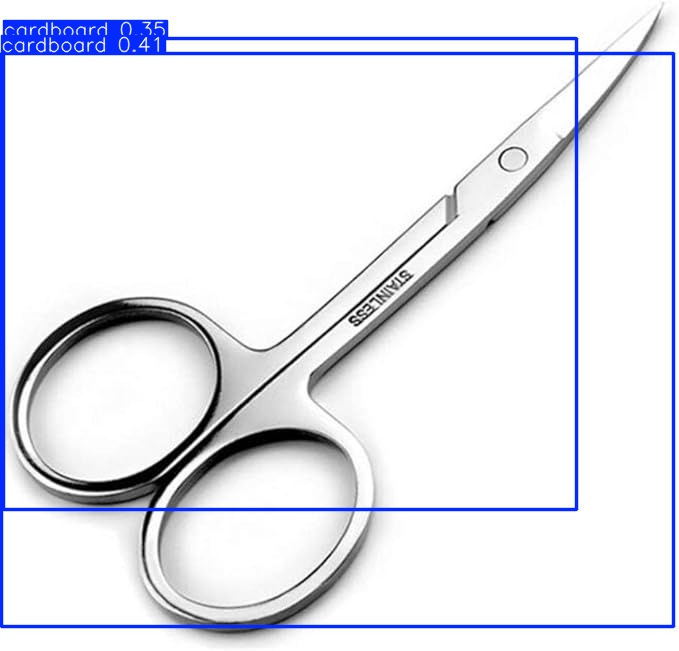

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/51nGJanMkfL._AC_SX679_.jpg')